In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Exercise 2: MC in the $NPT$ Ensemble

Enclosed is a program to simulate hard spheres of diameter $\sigma = 1$ in the
$NPT$ ensemble using MC.


In [2]:
# NPT SIMULATIONS OF HARD SPHERES WITH RANDOM WALK IN ln(V)

def mc_npt_lnV(number_of_cycles, number_of_initialization_cycles, number_of_particles, max_displacement, max_volume_change, beta, pressure):

    class Vector:
        def __init__(self, x=0.0, y=0.0, z=0.0):
            self.x = x
            self.y = y
            self.z = z

        def __repr__(self):
            return f"({self.x}, {self.y}, {self.z})"

    def write_pdb(file, positions, step):
        file.write(f"MODEL     {step+1}\n")
        for idx, pos in enumerate(positions):
            file.write(f"ATOM  {idx+1:5d}  H   MOL     1    {pos.x:8.3f}{pos.y:8.3f}{pos.z:8.3f}  1.00  0.00\n")
        file.write("ENDMDL\n")

    CYCLE_MULTIPLICATION = 500

    # Initialization
    num_displ_trials = 0
    num_displ_accepted = 0
    num_vol_trials = 0
    num_vol_accepted = 0
    volume_sum = 0
    volume_count = 0.0
    box = 10.0

    # Put particles on a lattice
    positions = [Vector(i * 1.1, j * 1.1, k * 1.1) 
                    for i in range(9) for j in range(9) for k in range(9)][:number_of_particles]
        
    # Start of the simulation
    with open("movie.pdb", "w") as file:
        write_pdb(file, positions, 0)

        for m in range(number_of_cycles):
            for _ in range(CYCLE_MULTIPLICATION):

                # Select particle and move at random 
                ipart = int(np.random.rand() * (number_of_particles + 1))
                if ipart >= number_of_particles:

                    # VOLUME CHANGE
                    num_vol_trials += 1
                    vold = box ** 3
                    box_old = box
                    # random walk in ln(V)
                    vnew = np.exp(np.log(vold) + (np.random.rand() - 0.5) * max_volume_change)
                    box = vnew ** (1/3)

                    # transform coordinates
                    old_positions = [Vector(p.x, p.y, p.z) for p in positions]

                    for p in positions:
                        p.x *= box / box_old
                        p.y *= box / box_old
                        p.z *= box / box_old

                    # check for overlaps
                    overlap = False
                    for i in range(number_of_particles - 1):
                        for j in range(i + 1, number_of_particles):
                            dx = positions[i].x - positions[j].x
                            dy = positions[i].y - positions[j].y
                            dz = positions[i].z - positions[j].z

                            # Apply periodic boundary conditions (nearest image)
                            dx -= box * round(dx / box)
                            dy -= box * round(dy / box)
                            dz -= box * round(dz / box)

                            r2 = dx**2 + dy**2 + dz**2
                            if r2 < 1.0:
                                overlap = True
                                break
                        if overlap:
                            break
                    
                    if (not overlap):
                        # Compute Metropolis acceptance criterion for volume change
                        if np.random.rand() < np.exp(-beta*pressure*(vnew-vold)+np.log(vnew/vold)*(number_of_particles+1)):
                            num_vol_accepted += 1

                        else:
                            # Reject the move: restore old positions and box
                            for i in range(number_of_particles):
                                positions[i].x = old_positions[i].x
                                positions[i].y = old_positions[i].y
                                positions[i].z = old_positions[i].z
                            box = box_old

                    else:
                        # Reject the move: restore old positions and box
                        for i in range(number_of_particles):
                            positions[i].x = old_positions[i].x
                            positions[i].y = old_positions[i].y
                            positions[i].z = old_positions[i].z
                        box = box_old

                # DISPLACEMENT
                else:
                    num_displ_trials += 1
                    pos = Vector(
                    positions[ipart].x + (np.random.rand() - 0.5) * max_displacement,
                    positions[ipart].y + (np.random.rand() - 0.5) * max_displacement,
                    positions[ipart].z + (np.random.rand() - 0.5) * max_displacement)

                    # Put the particle back in the box (apply periodic boundary conditions)
                    pos.x -= box * round(pos.x / box)
                    pos.y -= box * round(pos.y / box)
                    pos.z -= box * round(pos.z / box)

                    # Check for overlap with other particles
                    overlap = False
                    for i in range(number_of_particles):
                        if i != ipart:
                            # Calculate distance between particles
                            dr = Vector(pos.x - positions[i].x, pos.y - positions[i].y, pos.z - positions[i].z)

                            # Apply boundary conditions
                            dr.x -= box * round(dr.x / box)
                            dr.y -= box * round(dr.y / box)
                            dr.z -= box * round(dr.z / box)

                            r2 = dr.x**2 + dr.y**2 + dr.z**2
                            if r2 < 1.0:
                                overlap = True
                                break
                            
                    if not overlap:
                        # Accept the displacement
                        num_displ_accepted += 1
                        positions[ipart].x = pos.x
                        positions[ipart].y = pos.y
                        positions[ipart].z = pos.z

            if m % 10 == 0:
                write_pdb(file, positions, number_of_particles)
                print(f"Volume : {box**3:.2f}   Box : {box:.2f}")

            if m > number_of_initialization_cycles:
                volume_count += 1.0
                volume_sum += box**3

    return num_displ_accepted, num_displ_trials, num_vol_accepted, num_vol_trials, volume_sum, volume_count 


# Question 1: 
Why is it impossible to calculate the virial for this system directly?

<font color="#7777ff">

## Answer
The virial is calculated using the virial theorem, but for this one needs to have a continuous and differentiable
inter-particle potential $U(r)$. In the case of hard-spheres we have a discontinuous potential. It is set to be
$U(r)=\infty$ if $r\leq \sigma$, i.e. if we have particle overlap we reject the move and essentially have an infinite
inter-particle potential. However, if they don't overlap, we set $U(r) = 0$. So, the discontinuities and non
differentiability means that we cannot calculate the virial for this system directly.

In [3]:
# Initialize NPT Simulation Of Hard-Spheres

number_of_cycles = 500
number_of_initialization_cycles = 100
number_of_particles = 50
max_displacement = 1
max_volume_change = 0.01
beta = 1.
pressure = 1.

In [4]:
num_displ_accepted, num_displ_trials, num_vol_accepted, num_vol_trials, volume_sum, volume_count = mc_npt_lnV(number_of_cycles, number_of_initialization_cycles, number_of_particles, max_displacement, max_volume_change, beta, pressure)

print(f"Fraction Success (Displacement) : {num_displ_accepted / num_displ_trials:.6f}")
print(f"Fraction Success (Volume) : {num_vol_accepted / num_vol_trials:.6f}")
print(f"Average Volume : {volume_sum / volume_count:.6f}")
print(f"Average Density : {number_of_particles / (volume_sum / volume_count):.6f}")

Volume : 990.77   Box : 9.97
Volume : 878.82   Box : 9.58
Volume : 764.31   Box : 9.14
Volume : 674.70   Box : 8.77
Volume : 597.49   Box : 8.42
Volume : 545.62   Box : 8.17
Volume : 492.71   Box : 7.90
Volume : 447.75   Box : 7.65
Volume : 416.55   Box : 7.47
Volume : 404.26   Box : 7.39
Volume : 383.60   Box : 7.27
Volume : 378.13   Box : 7.23
Volume : 356.36   Box : 7.09
Volume : 333.30   Box : 6.93
Volume : 316.25   Box : 6.81
Volume : 294.36   Box : 6.65
Volume : 272.17   Box : 6.48
Volume : 251.79   Box : 6.31
Volume : 244.54   Box : 6.25
Volume : 232.22   Box : 6.15
Volume : 230.32   Box : 6.13
Volume : 216.13   Box : 6.00
Volume : 212.81   Box : 5.97
Volume : 208.16   Box : 5.93
Volume : 207.49   Box : 5.92
Volume : 196.66   Box : 5.82
Volume : 186.47   Box : 5.71
Volume : 177.45   Box : 5.62
Volume : 173.60   Box : 5.58
Volume : 170.80   Box : 5.55
Volume : 165.36   Box : 5.49
Volume : 164.91   Box : 5.48
Volume : 163.62   Box : 5.47
Volume : 163.90   Box : 5.47
Volume : 161.7

# Question 2: 
In the current code, a random walk is performed in $\ln\left(V\right)$ instead of $V$. Change the code in such a way that a random walk in $V$ is performed. Check that the average densities calculated by both algorithms are equal.

(Please note the difference in acceptance ratio in P187 (book version 3))


In [ ]:
# NPT SIMULATIONS OF HARD SPHERES WITH RANDOM WALK IN V

def mc_npt_V(number_of_cycles, number_of_initialization_cycles, number_of_particles, max_displacement, max_volume_change, beta, pressure):

    class Vector:
        def __init__(self, x=0.0, y=0.0, z=0.0):
            self.x = x
            self.y = y
            self.z = z

        def __repr__(self):
            return f"({self.x}, {self.y}, {self.z})"

    def write_pdb(file, positions, step):
        file.write(f"MODEL     {step+1}\n")
        for idx, pos in enumerate(positions):
            file.write(f"ATOM  {idx+1:5d}  H   MOL     1    {pos.x:8.3f}{pos.y:8.3f}{pos.z:8.3f}  1.00  0.00\n")
        file.write("ENDMDL\n")

    CYCLE_MULTIPLICATION = 500

    # initialization
    num_displ_trials = 0
    num_displ_accepted = 0
    num_vol_trials = 0
    num_vol_accepted = 0
    volume_sum = 0
    volume_count = 0.0
    box = 10.0

    # put particles on a lattice
    positions = [Vector(i * 1.1, j * 1.1, k * 1.1) 
                    for i in range(9) for j in range(9) for k in range(9)][:number_of_particles]
        
    # Start of the simulation
    with open("movie.pdb", "w") as file:
        write_pdb(file, positions, 0)

        for m in range(number_of_cycles):
            for _ in range(CYCLE_MULTIPLICATION):

                # Select particle and move at random 
                ipart = int(np.random.rand() * (number_of_particles + 1))
                if ipart >= number_of_particles:

                    # VOLUME CHANGE
                    num_vol_trials += 1
                    vold = box ** 3
                    box_old = box
                    # random volume walk in V
                    # start implementation
                    #vnew = None
                    
                    #vnew = vold + np.random.uniform(-max_volume_change, max_volume_change)
                    
                    #I dont know if I should take this one or the one above since the one below
                    #gets me closer to the average density from above. But the eq on top follows
                    #what the book says.
                    delta_lambda = (np.random.rand() - 0.5) * max_volume_change
                    vnew = vold * np.exp(delta_lambda) 
                    
                    
                    # end implementation
                    box = vnew ** (1/3)

                    # transform coordinates
                    old_positions = [Vector(p.x, p.y, p.z) for p in positions]

                    for p in positions:
                        p.x *= box / box_old
                        p.y *= box / box_old
                        p.z *= box / box_old

                    # check for overlaps
                    overlap = False
                    for i in range(number_of_particles - 1):
                        for j in range(i + 1, number_of_particles):
                            dx = positions[i].x - positions[j].x
                            dy = positions[i].y - positions[j].y
                            dz = positions[i].z - positions[j].z

                            # Apply periodic boundary conditions (nearest image)
                            dx -= box * round(dx / box)
                            dy -= box * round(dy / box)
                            dz -= box * round(dz / box)

                            r2 = dx**2 + dy**2 + dz**2
                            if r2 < 1.0:
                                overlap = True
                                break
                        if overlap:
                            break
                    
                    if (not overlap):
                        # Compute Metropolis acceptance criterion for volume change

                        # start implementation
                        if np.random.rand() < np.exp(-beta*pressure*(vnew-vold) + np.log(vnew/vold)*(number_of_particles)):
                        # end implementation
                            num_vol_accepted += 1
                        else:
                            # Reject the move: restore old positions and box
                            for i in range(number_of_particles):
                                positions[i].x = old_positions[i].x
                                positions[i].y = old_positions[i].y
                                positions[i].z = old_positions[i].z
                            box = box_old

                    else:
                        # Reject the move: restore old positions and box
                        for i in range(number_of_particles):
                            positions[i].x = old_positions[i].x
                            positions[i].y = old_positions[i].y
                            positions[i].z = old_positions[i].z
                        box = box_old

                # DISPLACEMENT
                else:
                    num_displ_trials += 1
                    pos = Vector(
                    positions[ipart].x + (np.random.rand() - 0.5) * max_displacement,
                    positions[ipart].y + (np.random.rand() - 0.5) * max_displacement,
                    positions[ipart].z + (np.random.rand() - 0.5) * max_displacement)


                    # Put the particle back in the box (apply periodic boundary conditions)
                    pos.x -= box * round(pos.x / box)
                    pos.y -= box * round(pos.y / box)
                    pos.z -= box * round(pos.z / box)

                    # Check for overlap with other particles
                    overlap = False
                    for i in range(number_of_particles):
                        if i != ipart:
                            # Calculate distance between particles
                            dr = Vector(pos.x - positions[i].x, pos.y - positions[i].y, pos.z - positions[i].z)

                            # Apply boundary conditions
                            dr.x -= box * round(dr.x / box)
                            dr.y -= box * round(dr.y / box)
                            dr.z -= box * round(dr.z / box)

                            r2 = dr.x**2 + dr.y**2 + dr.z**2
                            if r2 < 1.0:
                                overlap = True
                                break
                            
                    if not overlap:
                        # Accept the displacement
                        num_displ_accepted += 1
                        positions[ipart].x = pos.x
                        positions[ipart].y = pos.y
                        positions[ipart].z = pos.z

            if m % 10 == 0:
                write_pdb(file, positions, number_of_particles)
                print(f"Volume : {box**3:.2f}   Box : {box:.2f}")

            if m > number_of_initialization_cycles:
                volume_count += 1.0
                volume_sum += box**3

    return num_displ_accepted, num_displ_trials, num_vol_accepted, num_vol_trials, volume_sum, volume_count 


In [17]:
num_displ_accepted, num_displ_trials, num_vol_accepted, num_vol_trials, volume_sum, volume_count = mc_npt_V(number_of_cycles, number_of_initialization_cycles, number_of_particles, max_displacement, max_volume_change, beta, pressure)

print(f"Fraction Success (Displacement) : {num_displ_accepted / num_displ_trials:.6f}")
print(f"Fraction Success (Volume) : {num_vol_accepted / num_vol_trials:.6f}")
print(f"Average Volume : {volume_sum / volume_count:.6f}")
print(f"Average Density : {number_of_particles / (volume_sum / volume_count):.6f}")

Volume : 995.27   Box : 9.98
Volume : 889.92   Box : 9.62
Volume : 777.48   Box : 9.20
Volume : 700.66   Box : 8.88
Volume : 637.29   Box : 8.61
Volume : 591.89   Box : 8.40
Volume : 534.98   Box : 8.12
Volume : 493.84   Box : 7.90
Volume : 450.18   Box : 7.66
Volume : 430.17   Box : 7.55
Volume : 386.81   Box : 7.29
Volume : 358.54   Box : 7.10
Volume : 342.75   Box : 7.00
Volume : 329.00   Box : 6.90
Volume : 327.61   Box : 6.89
Volume : 307.70   Box : 6.75
Volume : 301.99   Box : 6.71
Volume : 281.21   Box : 6.55
Volume : 274.32   Box : 6.50
Volume : 262.52   Box : 6.40
Volume : 247.21   Box : 6.28
Volume : 231.20   Box : 6.14
Volume : 220.01   Box : 6.04
Volume : 215.15   Box : 5.99
Volume : 211.50   Box : 5.96
Volume : 205.37   Box : 5.90
Volume : 199.07   Box : 5.84
Volume : 195.50   Box : 5.80
Volume : 183.40   Box : 5.68
Volume : 178.35   Box : 5.63
Volume : 175.89   Box : 5.60
Volume : 170.36   Box : 5.54
Volume : 164.99   Box : 5.48
Volume : 159.98   Box : 5.43
Volume : 157.1

# Question 3: 
Make a plot of the acceptance ratio for volume displacements as a function of the maximum volume displacement for both
algorithms. Why could it be advantageous to sample in $\ln(V)$?

<font color="#7777ff">

## Answer
Sampling in $\ln(V)$ is advantageous primarily because it maintains a more consistent and appropriate relative step size across a wide range of possible volumes, which often leads to better sampling efficiency and more stable acceptance rates.



In [18]:
# list of maximum volume displacement
max_volume_change_list = [0.01, 0.05, 1]

# list for results
acceptance_ratio_volume_displacement_lnV = []
acceptance_ratio_volume_displacement_V = []

for max_volume_change in max_volume_change_list:

    # random walk in lnV
    num_displ_accepted, num_displ_trials, num_vol_accepted, num_vol_trials, volume_sum, volume_count = mc_npt_lnV(number_of_cycles, number_of_initialization_cycles, number_of_particles, max_displacement, max_volume_change, beta, pressure)
    acceptance_ratio_volume_displacement_lnV.append(num_vol_accepted / num_vol_trials)
    print(f"random walk in ln(V) - maximum volume displacement {max_volume_change}")
    print(f"Fraction Success (Volume) : {num_vol_accepted / num_vol_trials:.6f}")

    # random walk in V
    num_displ_accepted, num_displ_trials, num_vol_accepted, num_vol_trials, volume_sum, volume_count = mc_npt_V(number_of_cycles, number_of_initialization_cycles, number_of_particles, max_displacement, max_volume_change, beta, pressure)
    acceptance_ratio_volume_displacement_V.append(num_vol_accepted / num_vol_trials)
    print(f"random walk in V - maximum volume displacement {max_volume_change}")
    print(f"Fraction Success (Volume) : {num_vol_accepted / num_vol_trials:.6f}")

Volume : 980.41   Box : 9.93
Volume : 869.94   Box : 9.55
Volume : 797.17   Box : 9.27
Volume : 747.30   Box : 9.07
Volume : 692.00   Box : 8.85
Volume : 638.87   Box : 8.61
Volume : 586.05   Box : 8.37
Volume : 521.27   Box : 8.05
Volume : 467.91   Box : 7.76
Volume : 435.95   Box : 7.58
Volume : 407.52   Box : 7.41
Volume : 390.78   Box : 7.31
Volume : 353.00   Box : 7.07
Volume : 331.67   Box : 6.92
Volume : 303.75   Box : 6.72
Volume : 289.28   Box : 6.61
Volume : 268.83   Box : 6.45
Volume : 260.61   Box : 6.39
Volume : 248.37   Box : 6.29
Volume : 239.72   Box : 6.21
Volume : 225.69   Box : 6.09
Volume : 219.39   Box : 6.03
Volume : 209.40   Box : 5.94
Volume : 195.84   Box : 5.81
Volume : 191.81   Box : 5.77
Volume : 180.05   Box : 5.65
Volume : 169.26   Box : 5.53
Volume : 172.25   Box : 5.56
Volume : 168.06   Box : 5.52
Volume : 172.19   Box : 5.56
Volume : 173.23   Box : 5.57
Volume : 171.91   Box : 5.56
Volume : 166.72   Box : 5.50
Volume : 160.42   Box : 5.43
Volume : 156.3

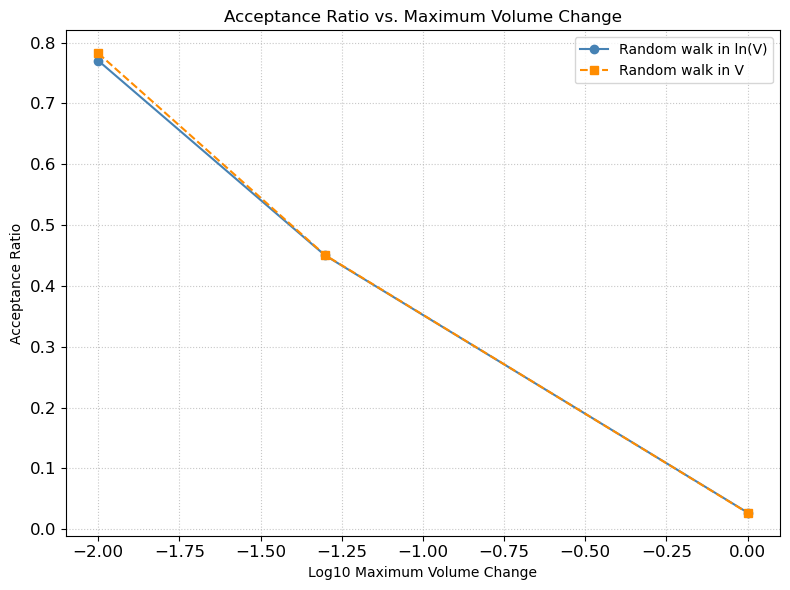

In [19]:
plt.figure(figsize=(8, 6))

plt.plot(np.log10(max_volume_change_list), acceptance_ratio_volume_displacement_lnV, 
         marker='o', linestyle='-', color='steelblue', label='Random walk in ln(V)')
plt.plot(np.log10(max_volume_change_list), acceptance_ratio_volume_displacement_V, 
         marker='s', linestyle='--', color='darkorange', label='Random walk in V')

plt.xlabel("Log10 Maximum Volume Change")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio vs. Maximum Volume Change")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tick_params(axis='both', labelsize=12)
plt.legend()

plt.tight_layout()
plt.show()